In [6]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

In [36]:
%load_ext autoreload
%autoreload 2

import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from make_line import make_data, get_grid, get_code

In [8]:
# x  (None,64,64)
# y0 (None,8,8,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None, (8,8) or 64,64,64) mask

szx,szy,szz=64,64,64
smx,smy=8,8
x_train, y_train0, y_train1 = make_data(N=1024)
x_val, y_val0, y_val1 = make_data(N=100)
x_test, y_test0, y_test1 = make_data(N=5)
grid, grid_anchor = get_grid()

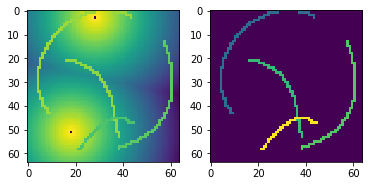

In [22]:
ind = -2
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())
region = np.argwhere(y_train0[ind,:,:,-1]==1)
print(region)
tmp = np.zeros((szx,szy))
r=1
if len(region.squeeze().shape) > 0:
    for x,y in region:
        code = smx*x+y
        print(code,x,smx,y,np.sum(y_train1[ind,x,y,code]))
        tmp[y_train1[ind,:,:,code].squeeze()==1]=r+1
        r+=1
plt.subplot(122)
plt.imshow(tmp)

In [9]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D
from keras.callbacks import LearningRateScheduler,EarlyStopping

from keras.models import Model
from keras.layers import Permute, Reshape, Lambda, add, Input, Concatenate
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras import regularizers, initializers

In [39]:
def viz_results(x_test,y_test0,ytest1,pred,szx,szy):
    obj_ind = -1
    #for ind in range(pred.shape[0]):
    for ind in range(5):

        plt.figure(ind,figsize=(20,10))
        #print(pred[0][ind,:,:,obj_ind])
        maxval = np.max(pred[0][ind,:,:,obj_ind])
        argmax = np.argwhere(pred[0][ind,:,:,obj_ind]==maxval)
        argmaxx,argmaxy=argmax[0]
        print(print(argmax.shape),argmax[0])
        
        print('pred',pred[0][ind,argmaxx,argmaxy,:])
        print('true',y_test0[ind,argmaxx,argmaxy,:])
        print('------')
        
        # GROUND TRUTH
        sa=plt.subplot(331)
        plt.title('sample index: {}, t:green, p:blue'.format(ind))
        sa.imshow(x_test[ind,:].squeeze())
        
        # overlay bounding box
        argmax = get_code(argmaxx,argmaxy,smx)
        ax,ay=grid_anchor[argmax]
        x,y,w,h,o = pred[0][ind,argmaxx,argmaxy,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='b',facecolor='none')
        sa.add_patch(rect)
        
        x,y,w,h,o = y_test0[ind,argmaxx,argmaxy,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='g',facecolor='none')
        sa.add_patch(rect)
        
        obj_real = y_test0[ind,:,:,obj_ind].squeeze()
        
        plt.subplot(332)
        plt.title('obj or not - truth'.format())
        plt.imshow(obj_real,cmap='gray')
        
        ax = plt.subplot(333)
        plt.title('obj or not - truth - actual val'.format())
        plt.plot(obj_real.ravel())
        ax.set_ylim(0,1)
        
        # PREDICTED
        
        obj = pred[0][ind,:,:,obj_ind].squeeze()
        
        plt.subplot(334)
        plt.title('obj or not - pred'.format())
        plt.imshow(obj,cmap='gray')
        plt.subplot(335)
        plt.title('obj or not - pred - actual val'.format())
        plt.imshow(obj,vmin=0,vmax=1,cmap='gray')
        
        ax = plt.subplot(336)
        plt.title('obj or not - pred - actual val'.format())
        plt.plot(obj.ravel())
        ax.set_ylim(0,1)

        if len(pred)>1:
            plt.subplot(337)
            plt.title('mask - pred'.format())
            
            plt.title('argmax {}'.format(argmax))
            plt.imshow(pred[1][ind,:,:,argmax].squeeze(),cmap='gray')
            #plt.imshow(pred[1][ind,argmaxx,argmaxy,:,:].squeeze(),cmap='gray')
            

In [19]:
# https://stackoverflow.com/questions/48810639/how-can-i-create-an-image-mask-tensor-from-unknown-number-of-bounding-boxes
USE_FOLD = True

def box_mask(box):
  """Create a 4x4 tensor of zeros except for a rectangle of ones defined by `box`"""
  x, y = 4, 4
  ymin, xmin, ymax, xmax = tf.unstack(box)
  h = xmax - xmin
  z0 = tf.zeros([xmin, y])
  z1 = tf.concat(
      [tf.zeros([h, ymin]),
       tf.ones([h, ymax - ymin]),
       tf.zeros([h, y - ymax])],
      axis=1)
  z2 = tf.zeros([x - xmax, y])
  return tf.concat([z0, z1, z2], axis=0)

def reduce_mask(a, box):
  mask = box_mask(box)
  return tf.maximum(a, mask)

def run():
  boxes_val = np.array([[0, 0, 2, 2], [2, 2, 4, 4]])
  boxes = tf.placeholder(shape=(None, 4), dtype=tf.int32)

  with tf.Session() as sess:
    if USE_FOLD:
      print(sess.run(tf.foldl(reduce_mask, boxes,
                              initializer=tf.zeros([4,4])),
                     feed_dict={boxes: boxes_val}))
    else:
      masks = tf.map_fn(box_mask, boxes, dtype=tf.float32)
      combined_mask = tf.reduce_max(masks, axis=0)
      print(sess.run(combined_mask, feed_dict={boxes: boxes_val}))
run()

[[1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]]


In [65]:

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

# actual yolos
#   https://pjreddie.com/media/files/papers/YOLO9000.pdf GOOD, others are helpful
#   https://github.com/ksanjeevan/dourflow/blob/master/net/netarch.py
#   https://github.com/guigzzz/Keras-Yolo-v2
#   https://hackernoon.com/understanding-yolo-f5a74bbc7967
# simple yolo # less intimidating, but not useable, good for intro.
#   https://gist.github.com/msrks/ce613e91a98868d4a059c6c5c5e30ba3
# vanillay conv cannot prediction coord
#   https://eng.uber.com/coordconv/
# alternative archetectures.
#   https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
#   https://github.com/jianing-sun/Mask-YOLO

epsilon = 1E-8
def compute_obj_loss(y_true,y_pred):
    return tf.reduce_mean(tf.keras.backend.binary_crossentropy(y_true[...,-1], y_pred[...,-1]))

def compute_coord_loss(y_true,y_pred):
    loss_px = tf.squared_difference(y_true[...,0],y_pred[...,0])
    loss_py = tf.squared_difference(y_true[...,1],y_pred[...,1])
    loss_wx = tf.squared_difference(y_true[...,2],y_pred[...,2])
    loss_wy = tf.squared_difference(y_true[...,3],y_pred[...,3])
    
    loss_pos = tf.add(loss_px,loss_py)
    loss_width = tf.add(loss_wx,loss_wy)
    
    coord_loss = tf.add(loss_pos,loss_width)
    coord_loss = tf.multiply(y_true[...,-1],coord_loss)
    return tf.reduce_mean(coord_loss)

def compute_iou_loss(y_true,y_pred):
    # ref. https://github.com/ksanjeevan/dourflow/blob/master/net/netloss.py
    def process_boxes(A):
        # ALign x-w, y-h
        A_xy = A[..., 0:2]
        A_wh = A[..., 2:4]
        
        A_wh_half = A_wh / 2.
        # Get x_min, y_min
        A_mins = A_xy - A_wh_half
        # Get x_max, y_max
        A_maxes = A_xy + A_wh_half
        
        return A_mins, A_maxes, A_wh
    
    # Process two sets
    A2_mins, A2_maxes, A2_wh = process_boxes(y_pred)
    A1_mins, A1_maxes, A1_wh = process_boxes(y_true)
    
    # Intersection as min(Upper1, Upper2) - max(Lower1, Lower2)
    intersect_mins  = K.maximum(A2_mins,  A1_mins)
    intersect_maxes = K.minimum(A2_maxes, A1_maxes)
    
    # Getting the intersections in the xy (aka the width, height intersection)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)

    # Multiply to get intersecting area
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # Values for the single sets
    true_areas = A1_wh[..., 0] * A1_wh[..., 1]
    pred_areas = A2_wh[..., 0] * A2_wh[..., 1]
    
    # Compute union for the IoU
    union_areas = pred_areas + true_areas - intersect_areas
    
    # probably not necssary...
    iou_loss = tf.multiply(y_true[...,-1], 1. - tf.truediv(intersect_areas,(union_areas+epsilon)) )
    
    return tf.reduce_mean(iou_loss)

def vec_loss(y_true, y_pred):
    
    lambda_obj = 1.0
    lambda_coord = 0.1
    lambda_iou = 1.0
    
    obj_loss = compute_obj_loss(y_true, y_pred)
    obj_loss = tf.multiply(lambda_obj,obj_loss)
    
    coord_loss = compute_coord_loss(y_true, y_pred)
    coord_loss = tf.multiply(lambda_coord,coord_loss)
    
    iou_loss = compute_iou_loss(y_true, y_pred)
    iou_loss = tf.multiply(lambda_iou,iou_loss)
    
    total_loss = tf.add(tf.add(obj_loss,coord_loss),iou_loss)
    
    return tf.reduce_mean(total_loss)

# https://github.com/keras-team/keras/issues/3611
def dice_coef(y_true, y_pred, smooth=1e-3):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return (2. * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):    
    dice = 1-dice_coef(y_true, y_pred)
    # get rid of dice where there is no object.
    is_obj = K.sum(y_true, axis=[1,2])
    is_obj = K.greater(is_obj,0.5*K.ones_like(is_obj))
    dice = tf.boolean_mask(dice, is_obj)
    return tf.reduce_mean(dice)

def conv_batch_lrelu(input_tensor, numfilter, dim, strides=1):
    # https://github.com/guigzzz/Keras-Yolo-v2/blob/f61286371cdc2d470e0811234f552c70bbd5caba/yolo_layer_utils.py#L18
    input_tensor = Conv2D(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

def convt_batch_lrelu(input_tensor, numfilter, dim, strides=1):
    input_tensor = Conv2DTranspose(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

MASK = 'MASK'
VECTOR = 'VECTOR'

inputs = Input(shape=(szx,szy,1))

dropoutrate = 0.4

# down sample
xd = conv_batch_lrelu(inputs, 16, 3)
xd = MaxPooling2D(pool_size=(2, 2),strides=2)(xd)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 32, 3)
xd = MaxPooling2D(pool_size=(2, 2),strides=2)(xd)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 64, 3)
xd = conv_batch_lrelu(xd, 32, 1)
xd = conv_batch_lrelu(xd, 64, 3)
xd = MaxPooling2D(pool_size=(2, 2),strides=2)(xd)
xd=Dropout(dropoutrate)(xd)

# to coord & obj
xb = conv_batch_lrelu(xd, 128, 3)
xb = conv_batch_lrelu(xb, 64, 1)
xb = conv_batch_lrelu(xb, 128, 3)
xb = Dropout(dropoutrate)(xb)
xb = conv_batch_lrelu(xb, 64, 1)
xb = conv_batch_lrelu(xb, 128, 3)
xb = Conv2D(5, (1, 1), strides=1, padding='same',use_bias=False)(xb)
vecs=Activation('sigmoid',name=VECTOR)(xb)

# up sample
merged = Concatenate(axis=-1,)([xd,vecs])
xu = convt_batch_lrelu(merged, 64, 3) # can just use conv_batch_lrelu if using upsampling2d...
xu = convt_batch_lrelu(xu, 32, 1)
xu = convt_batch_lrelu(xu, 64, 3)
xu = UpSampling2D(size=(2,2),interpolation='nearest')(xu)
xu = convt_batch_lrelu(xu, 32, 3)
xu = UpSampling2D(size=(2,2),interpolation='nearest')(xu)
xu = convt_batch_lrelu(xu, 16, 3)
xu = UpSampling2D(size=(2,2),interpolation='nearest')(xu)

'''
#for k,v in grid.items():
#    print(get_code(x,y,smx),v)
#ax,ay=grid_anchor[(x,y)]

# make 
def get_boxed(vecs):
    # convert 8x8,5 to 64,5
    # make mask, 64x64,64
    # draw box per mask
    
    med_x = vecs[...,0]
    med_y = vecs[...,1]
    dim_x = vecs[...,2]
    dim_y = vecs[...,3]
    isobj = vecs[...,4]
    
    
    
    
if code not in anchor_dict.keys():
    anchor_dict[code]=(x,y)
grid[(x,y)]=(code,px,py)
get_code(px,py,smx):
    
    vecs
boxes = get_boxed(vecs)

xu = Concatenate(axis=-1,)([xu,boxes])
'''

xu = Conv2D(64, (1, 1), strides=1, padding='same',use_bias=False)(xu)
masks=Activation('sigmoid',name=MASK)(xu)

# merge outputs
model = Model(inputs=inputs, outputs=[vecs,masks])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 64, 64, 16)   144         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_109 (BatchN (None, 64, 64, 16)   64          conv2d_93[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_109 (LeakyReLU)     (None, 64, 64, 16)   0           batch_normalization_109[0][0]    
__________________________________________________________________________________________________
max_poolin

In [ ]:

yolo_loss = {
    MASK: dice_coef_loss,
    VECTOR: vec_loss,
}
loss_weights = {
    MASK: 1.,
    VECTOR: 1.,
}

verbose=1
batch_size=32
epochs=1000
lr=1E-3
decay=1E-3
patience=10
beta_1=0.9
beta_2=0.999

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=patience,
                              verbose=0,
                              mode='min')

callbacks = [early_stopping]
optimizer = opt.Adam(lr=lr,beta_1=beta_1, beta_2=beta_2, decay=decay)
model.compile(loss=yolo_loss, loss_weights=loss_weights, optimizer=optimizer)
history = model.fit(x_train, {VECTOR:y_train0,MASK:y_train1},
                    batch_size=batch_size, epochs=epochs,
                    verbose=verbose, 
                    validation_data=(x_val, {VECTOR:y_val0, MASK:y_val1}),
                    callbacks=callbacks)
# no merge 
# 0.9,1.1
# merge at 8x8
# 0.6, 0.7
# bug fix, dice sum axis (from 2,3 to 1,2), and is_obj > 0 from to is_obj > 0.5
# 

Train on 1024 samples, validate on 100 samples
Epoch 1/1000
1024/1024 [==============================] - 8s 8ms/step - loss: 2.6047 - VECTOR_loss: 0.3747 - MASK_loss: 0.9707 - val_loss: 2.3188 - val_VECTOR_loss: 0.2439 - val_MASK_loss: 0.9711
Epoch 2/1000
1024/1024 [==============================] - 2s 2ms/step - loss: 2.1432 - VECTOR_loss: 0.1956 - MASK_loss: 0.9684 - val_loss: 2.0098 - val_VECTOR_loss: 0.1794 - val_MASK_loss: 0.9711
Epoch 3/1000
1024/1024 [==============================] - 2s 2ms/step - loss: 1.9014 - VECTOR_loss: 0.1689 - MASK_loss: 0.9643 - val_loss: 1.8227 - val_VECTOR_loss: 0.1719 - val_MASK_loss: 0.9700
Epoch 4/1000
1024/1024 [==============================] - 2s 2ms/step - loss: 1.7310 - VECTOR_loss: 0.1589 - MASK_loss: 0.9585 - val_loss: 1.6826 - val_VECTOR_loss: 0.1648 - val_MASK_loss: 0.9691
Epoch 5/1000
1024/1024 [==============================] - 2s 2ms/step - loss: 1.6032 - VECTOR_loss: 0.1534 - MASK_loss: 0.9515 - val_loss: 1.5772 - val_VECTOR_loss: 0.16

In [ ]:
df = pd.DataFrame(history.history)
df.plot()

In [ ]:
x_0, y_0, y_1 = x_train, y_train0, y_train1
out = model.evaluate(x_0,{VECTOR:y_0, MASK:y_1})
print('train',out)
x_0, y_0, y_1 = x_val, y_val0, y_val1
out = model.evaluate(x_0,{VECTOR:y_0, MASK:y_1})
print('val',out)
x_0, y_0, y_1 = x_test, y_test0, y_test1
out = model.evaluate(x_0,{VECTOR:y_0, MASK:y_1})
print('test',out)

In [ ]:
x_0, y_0, y_1 = x_test, y_test0, y_test1
#x_0, y_0, y_1 = x_train, y_train0, y_train1
#x_0, y_0, y_1 = x_val, y_val0, y_val1
pred = model.predict(x_0)
viz_results(x_0,y_0,y_1,pred,szx,szy)